In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0"

In [ ]:
!pip install d2l==1.0.0b0

### AlexNet

In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                                   activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                                   activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                                   activation='relu'),
            tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                                   activation='relu'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                                   activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes)])

We construct a single-channel data example with both height and width of 224 to observe the output shape of each layer. It matches the AlexNet architecture in the slides

In [ ]:
AlexNet().layer_summary((1, 224, 224, 1))

Although AlexNet was trained on ImageNet in Krizhevsky et al. (2012), we use Fashion-MNIST here since training an ImageNet model to convergence could take hours or days even on a modern GPU. One of the problems with applying AlexNet directly on Fashion-MNIST is that its images have lower resolution (28x28 pixels) than ImageNet images. To make things work, we upsample them to 224x224. This is generally not a smart practice, as it simply increases the computational complexity without adding information. Nonetheless, we do it here to be faithful to the AlexNet architecture. We perform this resizing with the resize argument in the `d2l.FashionMNIST` constructor.

Now, we can start training AlexNet. Here, we use a smaller learning rate and much slower training due to the deeper and wider network, the higher image resolution, and the more costly convolutions.

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
# data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
data = d2l.FashionMNIST(batch_size=32, resize=(128, 128))
with d2l.try_gpu():
    model = AlexNet(lr=0.01)
    trainer.fit(model, data)

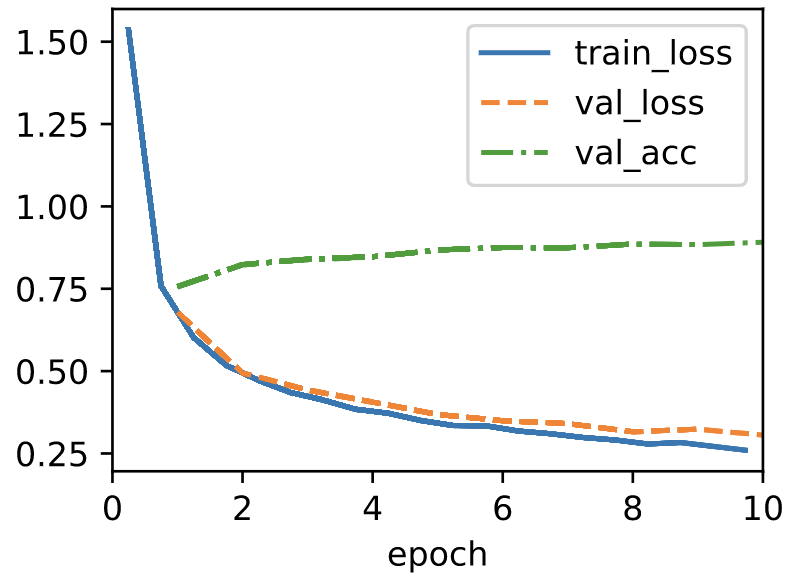

### Networks Using Blocks (VGG)

In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

The function below takes two arguments, corresponding to the number of convolutional layers `num_convs` and the number of output channels `num_channels`.

In [ ]:
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(
            tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                   padding='same', activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

In [ ]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential()
        for (num_convs, num_channels) in arch:
            self.net.add(vgg_block(num_convs, num_channels))
        self.net.add(
            tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes)]))

The original VGG network had 5 convolutional blocks, among which the first two have one convolutional layer each and the latter three contain two convolutional layers each. The first block has 64 output channels and each subsequent block doubles the number of output channels, until that number reaches 512. Since this network uses 8 convolutional layers and 3 fully connected layers, it is often called VGG-11.

In [ ]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 224, 224, 1))

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
with d2l.try_gpu():
    model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
    trainer.fit(model, data)

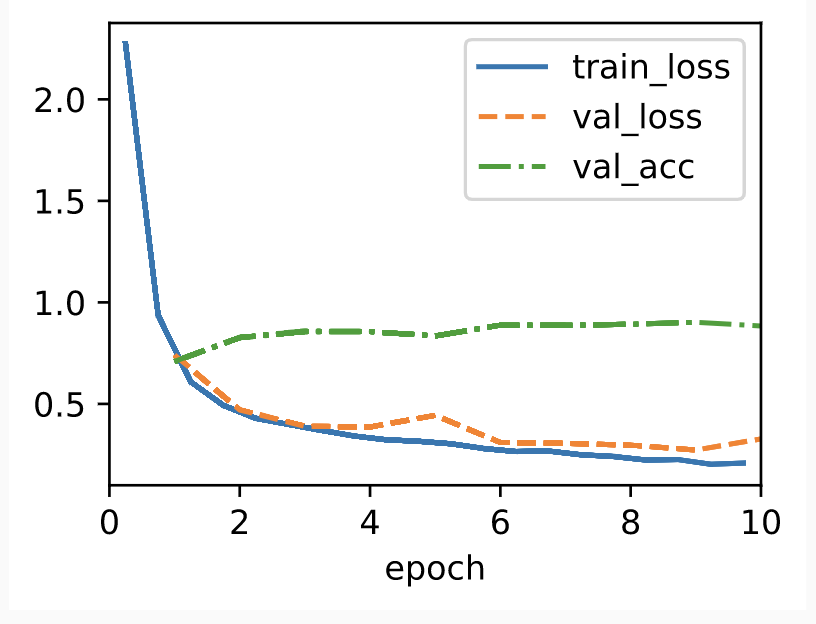

### Network in Network (NiN)

In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
def nin_block(out_channels, kernel_size, strides, padding):   # build NiN block
    return tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(out_channels, kernel_size, strides=strides,
                           padding=padding),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(out_channels, 1),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(out_channels, 1),
    tf.keras.layers.Activation('relu')])

In [ ]:
class NiN(d2l.Classifier):    # build NiN model
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            nin_block(96, kernel_size=11, strides=4, padding='valid'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            nin_block(256, kernel_size=5, strides=1, padding='same'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            nin_block(384, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.GlobalAvgPool2D(),
            tf.keras.layers.Flatten()])

We create a data example to see the output shape of each block.

In [ ]:
NiN().layer_summary((1, 224, 224, 1))

As before we use Fashion-MNIST to train the model using the same optimizer that we used for AlexNet and VGG.

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
with d2l.try_gpu():
    model = NiN(lr=0.05)
    trainer.fit(model, data)

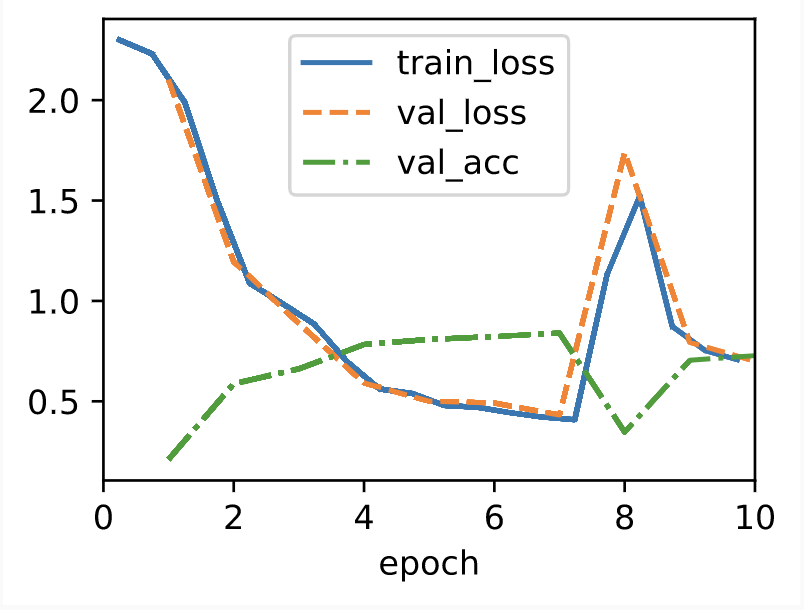

### Multi-Branch Networks (GoogLeNet)

In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
class Inception(tf.keras.Model):    # build inception blocks
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        self.b1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')
        self.b2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.b2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
        self.b3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.b3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
        self.b4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.b4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')

    def call(self, x):
        b1 = self.b1_1(x)
        b2 = self.b2_2(self.b2_1(x))
        b3 = self.b3_2(self.b3_1(x))
        b4 = self.b4_2(self.b4_1(x))
        return tf.keras.layers.Concatenate()([b1, b2, b3, b4])

We can now implement GoogLeNet piece by piece. Let’s begin with the stem. The first module uses a 64-channel 7x7 convolutional layer.

In [ ]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64, 7, strides=2, padding='same',
                                   activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2,
                                      padding='same')])

The second module uses two convolutional layers: first, a 64-channel  convolutional layer, followed by a  convolutional layer that triples the number of channels. This corresponds to the second branch in the Inception block and concludes the design of the body. At this point we have 192 channels.

In [ ]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 1, activation='relu'),
        tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

The third module connects two complete Inception blocks in series. The number of output channels of the first Inception block is 64 + 128 + 32 + 32 = 256. This amounts to a ratio of the number of output channels among the four branches of 2 : 4 : 1 : 1 . Achieving this, we first reduce the input dimensions by 1/2 and by 1/12 in the second and third branch respectively to arrive at 96 = 192/2 and 16 = 192/12 channels respectively.

The number of output channels of the second Inception block is increased to 128 + 192 + 96 + 64 = 480, yielding a ratio of 128 : 192 : 96 : 64 = 4 : 6 : 3 : 2. As before, we need to reduce the number of intermediate dimensions in the second and third channel. A scale of 1/2 and 1/8 respectively suffices, yielding 128 and 32 channels respectively. This is captured by the arguments of the following `Inception` block constructors.

In [ ]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return tf.keras.models.Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

The fourth module is more complicated. It connects five Inception blocks in series, and they have 192 + 208 + 48 + 64 = 512, 160 + 224 + 64 + 64 = 512, 128 + 256 + 64 + 64 = 512, 112 + 288 + 64 + 64 = 528, and 256 + 320 + 128 + 128 = 832 output channels, respectively. The number of channels assigned to these branches is similar to that in the third module: the second branch with the 3x3 convolutional layer outputs the largest number of channels, followed by the first branch with only the 1x1 convolutional layer, the third branch with the 5x5 convolutional layer, and the fourth branch with the 3x3 max-pooling layer. The second and third branches will first reduce the number of channels according to the ratio. These ratios are slightly different in different Inception blocks.

In [ ]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return tf.keras.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

The fifth module has two Inception blocks with 256 + 320 + 128 + 128 = 832 and 384 + 384 + 128 + 128 = 1024 output channels. The number of channels assigned to each branch is the same as that in the third and fourth modules, but differs in specific values. It should be noted that the fifth block is followed by the output layer. This block uses the global average pooling layer to change the height and width of each channel to 1, just as in NiN. Finally, we turn the output into a two-dimensional array followed by a fully connected layer whose number of outputs is the number of label classes.

In [ ]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return tf.keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Flatten()])

Now that we defined all blocks `b1` through `b5`, it is just a matter of assembling them all into a full network.

In [ ]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = tf.keras.Sequential([
        self.b1(), self.b2(), self.b3(), self.b4(), self.b5(),
        tf.keras.layers.Dense(num_classes)])

The GoogLeNet model is computationally complex. Note the large number of relatively arbitrary hyperparameters in terms of the number of channels chosen, the number of blocks prior to dimensionality reduction, the relative partitioning of capacity across channels, etc. Much of it is due to the fact that at the time when GoogLeNet was introduced, automatic tools for network definition or design exploration were not yet available. For instance, by now we take it for granted that a competent deep learning framework is capable of inferring dimensionalities of input tensors automatically. At the time, many such configurations had to be specified explicitly by the experimenter, thus often slowing down active experimentation. Moreover, the tools needed for automatic exploration were still in flux and initial experiments largely amounted to costly brute force exploration, genetic algorithms, and similar strategies.

For now the only modification we will carry out is to reduce the input height and width from 224 to 96 to have a reasonable training time on Fashion-MNIST. This simplifies the computation. Let’s have a look at the changes in the shape of the output between the various modules.

In [ ]:
model = GoogleNet().layer_summary((1, 96, 96, 1))

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 192)
Sequential output shape:	 (1, 6, 6, 480)
Sequential output shape:	 (1, 3, 3, 832)
Sequential output shape:	 (1, 1024)
Dense output shape:	 (1, 10)


As before, we train our model using the Fashion-MNIST dataset. We transform it to 96x96 pixel resolution before invoking the training procedure.

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
with d2l.try_gpu():
    model = GoogleNet(lr=0.01)
    trainer.fit(model, data)

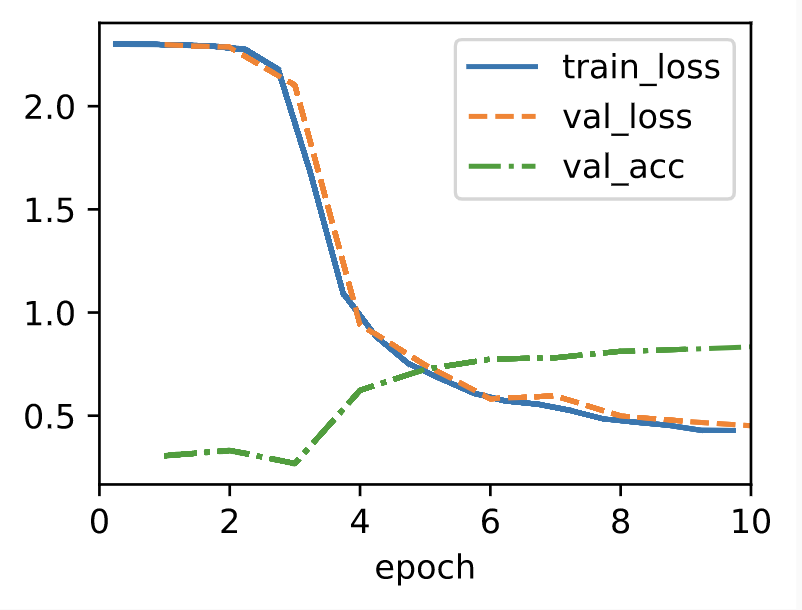